# Load the raw dataset

In [49]:
import torchaudio

data = torchaudio.datasets.LIBRITTS(root="data", url="train-clean-100", download=True)

# Convert audio to spectrogram

First, visualize the plain waveform for a particular audio file:

In [50]:
%pip install scipy matplotlib

Speaker ID: 1034
Chapter ID: 121119
Utterance ID: 1034_121119_000019_000001
Original text: Your name?"
Normalized text: Your name?"

Waveform shape: torch.Size([1, 17520])
Waveform shape (squeezed): torch.Size([17520])
Sample rate: 24000 Hz


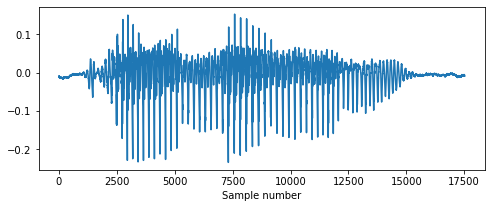

In [51]:
import scipy
import matplotlib.pyplot as plt

# Fixes dead kernel issue on my computer
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

item = data[7]
waveform, sample_rate, original_text, normalized_text, speaker_id, chapter_id, utterance_id = item

print(f"Speaker ID: {speaker_id}")
print(f"Chapter ID: {chapter_id}")
print(f"Utterance ID: {utterance_id}")
print(f"Original text: {original_text}")
print(f"Normalized text: {normalized_text}")
print()
print(f"Waveform shape: {waveform.shape}")
print(f"Waveform shape (squeezed): {waveform.squeeze().shape}")
print(f"Sample rate: {sample_rate} Hz")

plt.figure(figsize=(8,3))
plt.plot(waveform.t().numpy())
plt.xlabel("Sample number")
plt.show()

Then, generate a spectrogram and render it:

(129,) float64
(78,) float64
(129, 78) float32


<ipython-input-52-99b9147dc289>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(times, frequencies, spectrogram)


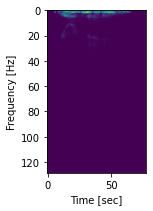

In [52]:
from scipy import signal

frequencies, times, spectrogram = signal.spectrogram(waveform.squeeze(), sample_rate)

print(frequencies.shape, frequencies.dtype)
print(times.shape, times.dtype)
print(spectrogram.shape, spectrogram.dtype)

plt.figure(figsize=(8,3))
plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [53]:
%pip install pickle5
%pip install soundfile


  Using cached pickle5-0.0.11.tar.gz (132 kB)
  Running setup.py clean for pickle5


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\sanin\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\sanin\\AppData\\Local\\Temp\\pip-install-dguuj29_\\pickle5_22795898b4954928aa7c670cbf96a996\\setup.py'"'"'; __file__='"'"'C:\\Users\\sanin\\AppData\\Local\\Temp\\pip-install-dguuj29_\\pickle5_22795898b4954928aa7c670cbf96a996\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\sanin\AppData\Local\Temp\pip-wheel-ob_55ye6'
       cwd: C:\Users\sanin\AppData\Local\Temp\pip-install-dguuj29_\pickle5_22795898b4954928aa7c670cbf96a996\
  Complete output (36 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.win-amd64-3.8\pickle5
  copying pickle5\pickle.py -> build\lib.win-amd64-3.8\pickle5
  cop

Failed to build pickle5
    Running setup.py install for pickle5: started
    Running setup.py install for pickle5: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


# Generate training set (examples 0 - 3999 from dataset)

This will create a file called `prepared-data/dataset_4000.pkl` which contains the first 4000 examples from the dataset.

In [63]:
import pickle
import scipy
import torch
from scipy import signal

prepared_data = []

for n in range(4):
    for i in range(1000):
        item = data[i + n * 1000]
        waveform, sample_rate, original_text, normalized_text, speaker_id, chapter_id, utterance_id = item
        frequencies, times, spectrogram = signal.spectrogram(waveform.squeeze(), sample_rate)
        
        for i in range(100):
            spectrogram[i] = spectrogram[i][:10000]
            
        spectrogram = torch.from_numpy(spectrogram[:100])

#     prepared_data.append({
#       "waveform": waveform,
#       "spectrogram": spectrogram,
#       "sample_rate": sample_rate,
#       "original_text": original_text,
#       "normalized_text": normalized_text,
#       "speaker_id": speaker_id,
#       "chapter_id": chapter_id,
#       "utterance_id": utterance_id
#     })

        prepared_data.append([spectrogram, normalized_text])
    
    print(spectrogram.shape)
    with open("prepared-data/dataset_4000.pkl", "wb") as f:
        print(f"Dumping {len(prepared_data)} examples")
        pickle.dump(prepared_data, f)


torch.Size([100, 863])
Dumping 1000 examples
torch.Size([100, 1061])
Dumping 2000 examples
torch.Size([100, 730])
Dumping 3000 examples
torch.Size([100, 868])
Dumping 4000 examples


# Generate test set (examples 5000 - 5999 from dataset)

This will create a file called `prepared-data/dataset_1000.pkl` which contains 1000 examples from the dataset.

I am using 5000-5999 rather than 4000-4999 because when I tried 4000-4999, it failed and said the file was too big. I assume there are a few massive audio files in that range?

In [65]:
prepared_data = []

for i in range(1000):
    item = data[i + 5000] # Using 5000-5999 rather than 4000-4999 because when I tried 4000-4999, it failed and said the file was too big. I assume there are a few massive audio files in there?
    waveform, sample_rate, original_text, normalized_text, speaker_id, chapter_id, utterance_id = item
    frequencies, times, spectrogram = scipy.signal.spectrogram(waveform.squeeze(), sample_rate)

    for i in range(100):
        spectrogram[i] = spectrogram[i][:10000]
            
    spectrogram = torch.from_numpy(spectrogram[:100])
#   prepared_data.append({
#     "spectrogram": spectrogram,
#     "sample_rate": sample_rate,
#     "original_text": original_text,
#     "normalized_text": normalized_text,
#     "speaker_id": speaker_id,
#     "chapter_id": chapter_id,
#     "utterance_id": utterance_id
#   })
    
    prepared_data.append([spectrogram, normalized_text])

with open("prepared-data/dataset_1000.pkl", "wb") as f:
    print(f"Dumping {len(prepared_data)} examples")
    pickle.dump(prepared_data, f)

Dumping 1000 examples
